# This requires a set of geospatial packages not included in ewatercycle


In [1]:
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
from IPython.display import IFrame
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import sys
import os
import xarray as xr
from datetime import datetime
from pathlib import Path

In [2]:
path = Path.cwd()

figure_path = path / "Figures"
analysis_path = path / "Analysis" 

## load characteristic files

In [3]:
geospatial_files = analysis_path / "camels_characteristics" 

In [4]:
lst_paths_characteristic = list(geospatial_files.glob('*.feather'))

In [5]:
lst_char_df = []
for path in lst_paths_characteristic:
    df = pd.read_feather(path).set_index('gauge_id')
    df.index.name = "HRU_id"
    lst_char_df.append(df)

In [6]:
df_char_names = lst_char_df[0]
df_char_names.head(3)

,huc_02,gauge_name
HRU_id,,
1013500,1,"Fish River near Fort Kent, Maine"
1022500,1,"Narraguagus River at Cherryfield, Maine"
1030500,1,"Mattawamkeag River near Mattawamkeag, Maine"


In [7]:
df_char_clim = lst_char_df[1]
df_char_clim.head(3)

,p_mean,pet_mean,p_seasonality,frac_snow,aridity,high_prec_freq,high_prec_dur,high_prec_timing,low_prec_freq,low_prec_dur,low_prec_timing
HRU_id,,,,,,,,,,,
1013500,3.126679,1.971555,0.187940,0.313440,0.630559,12.95,1.348958,son,202.20,3.427119,mam
1022500,3.608126,2.119256,-0.114530,0.245259,0.587356,20.55,1.205279,son,233.65,3.662226,jja
1030500,3.274405,2.043594,0.047358,0.277018,0.624111,17.15,1.207746,son,215.60,3.514262,djf


In [8]:
df_char_geol = lst_char_df[2]
df_char_geol.head(3)

,geol_1st_class,glim_1st_class_frac,geol_2nd_class,glim_2nd_class_frac,carbonate_rocks_frac,geol_porostiy,geol_permeability
HRU_id,,,,,,,
1013500,Siliciclastic sedimentary rocks,0.815904,Basic volcanic rocks,0.179729,0.00000,0.1714,-14.7019
1022500,Acid plutonic rocks,0.590658,Siliciclastic sedimentary rocks,0.164618,0.00000,0.0710,-14.2138
1030500,Siliciclastic sedimentary rocks,0.573305,Metamorphics,0.287010,0.05214,0.1178,-14.4918


In [9]:
df_char_hydro= lst_char_df[3]
df_char_hydro.head(3)

,q_mean,runoff_ratio,slope_fdc,baseflow_index,stream_elas,q5,q95,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq,hfd_mean
HRU_id,,,,,,,,,,,,,
1013500,1.699155,0.543437,1.528219,0.585226,1.845324,0.241106,6.373021,6.10,8.714286,41.35,20.170732,0.0,207.25
1022500,2.173062,0.602269,1.776280,0.554478,1.702782,0.204734,7.123049,3.90,2.294118,65.15,17.144737,0.0,166.25
1030500,1.820108,0.555859,1.871110,0.508441,1.377505,0.107149,6.854887,12.25,7.205882,89.25,19.402174,0.0,184.90


In [10]:
df_char_soil = lst_char_df[4]
df_char_soil.head(3)

,soil_depth_pelletier,soil_depth_statsgo,soil_porosity,soil_conductivity,max_water_content,sand_frac,silt_frac,clay_frac,water_frac,organic_frac,other_frac
HRU_id,,,,,,,,,,,
1013500,7.404762,1.248408,0.461149,1.106522,0.558055,27.841827,55.156940,16.275732,5.376698,0.408717,0.000000
1022500,17.412808,1.491846,0.415905,2.375005,0.626229,59.390156,28.080937,12.037646,1.226913,0.000000,0.358472
1030500,19.011414,1.461363,0.459091,1.289807,0.653020,32.235458,51.779182,14.776824,1.634345,1.330278,0.022016


In [11]:
df_char_vege = lst_char_df[5]
df_char_vege.head(3)

,frac_forest,lai_max,lai_diff,gvf_max,gvf_diff,dom_land_cover_frac,dom_land_cover,root_depth_50,root_depth_99
HRU_id,,,,,,,,,
1013500,0.9063,4.167304,3.340732,0.804567,0.371648,0.883452,Mixed Forests,NaN,NaN
1022500,0.9232,4.871392,3.746692,0.863936,0.337712,0.820493,Mixed Forests,0.237435,2.238444
1030500,0.8782,4.685200,3.665543,0.858502,0.351393,0.975258,Mixed Forests,NaN,NaN


In [12]:
gdf_catchments = gpd.read_file(geospatial_files / "catchments.gpkg")
gdf_catchments = gdf_catchments[['hru_id','geometry']]
gdf_catchments = gdf_catchments.set_index('hru_id')
gdf_catchments.index.name = "HRU_id"

<Axes: >

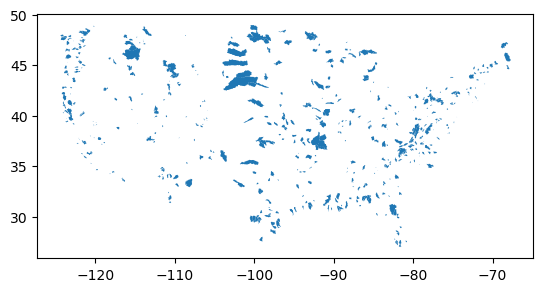

In [13]:
gdf_catchments.plot()

In [14]:
gdf_gauges = gpd.read_file(geospatial_files / "gauges.gpkg")
gdf_gauges = gdf_gauges.set_index('gauge_id')
gdf_gauges.index.name = "HRU_id"
gdf_gauges

,gauge_lat,gauge_lon,elev_mean,slope_mean,area_gages2,area_geospa_fabric,geometry
HRU_id,,,,,,,
1013500,47.23739,-68.58264,250.31,21.64152,2252.70,2303.95,POINT (-68.58264 47.23739)
1022500,44.60797,-67.93524,92.68,17.79072,573.60,620.38,POINT (-67.93524 44.60797)
1030500,45.50097,-68.30596,143.80,12.79195,3676.17,3676.09,POINT (-68.30596 45.50097)
1031500,45.17501,-69.31470,247.80,29.56035,769.05,766.53,POINT (-69.31470 45.17501)
1047000,44.86920,-69.95510,310.38,49.92122,909.10,904.94,POINT (-69.95510 44.86920)
...,...,...,...,...,...,...,...
14309500,42.80400,-123.61091,709.83,110.42527,224.92,226.31,POINT (-123.61091 42.80400)
14316700,43.34984,-122.72894,952.26,119.08920,587.90,588.01,POINT (-122.72894 43.34984)
14325000,42.89150,-124.07065,656.53,124.96889,443.07,444.92,POINT (-124.07065 42.89150)


In [15]:
hru_id_cal = ['01137500',
            '01139800',
            '01187300',
            '01052500',
            '01073000',
            '01181000',
            '01169000',
            '01013500',
            '01123000',
            '01055000',
            '01047000',
            '04296000',
            '01022500',
            '01134500',
            '01170100',
            '01142500',
            '01144000',
            '01054200',
            '01031500',
            '01139000',
            '01057000',
            '01078000',
            '01162500',
            '01030500',
            '01118300',
            '01121000']
for index, ids in enumerate(hru_id_cal):
    hru_id_cal[index] = int(ids)
gdf_callibration_catchment = gdf_catchments.loc[hru_id_cal]
gdf_callibration_gauges = gdf_gauges.loc[hru_id_cal]

### plotting to check 

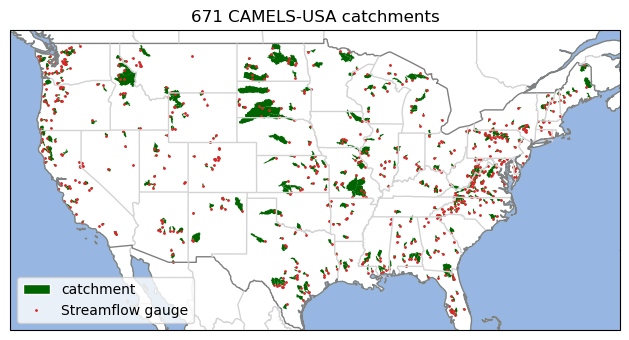

In [16]:
# set up background maps
ax = plt.axes(projection=ccrs.PlateCarree())
country_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='10m',
    facecolor='none')
ax.add_feature(country_borders, edgecolor='gray')

state_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
ax.add_feature(state_borders, edgecolor='lightgray')
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, edgecolor='lightblue')

# add legend properties
ms = 1
color = "C3"
catchment_color = "darkgreen"
gdf_catchments.plot(ax=ax,facecolor=catchment_color)
gdf_gauges.plot(ax=ax,markersize=ms,color=color)

ax.set_title(f"{len(gdf_catchments)} CAMELS-USA catchments")
# add legend
legend_gauges = matplotlib.lines.Line2D([],[],color=color,markersize=ms,marker="o",linewidth=0,label='Streamflow gauge')
legend_catchments = matplotlib.patches.Patch(facecolor=catchment_color, edgecolor='w',label=f"catchment")
ax.legend(loc='best', handles=ax.get_legend_handles_labels()[0] + [legend_catchments,legend_gauges])
          
plt.tight_layout()
# plt.savefig(fr'{figures_path}\CAMELS-USA-catchments-with_gauges.png',bbox_inches="tight")

## load results

In [17]:
ds = xr.open_dataset(analysis_path / 'results_analysis_229_catchments.nc')

In [18]:
df_res_all_ran = pd.read_feather(analysis_path / 'all_catchments_NSE.feather')

df_res_all = pd.read_feather(analysis_path / 'catchments_NSE_gt_0.feather')
df_res_all['HRU_id'] = df_res_all['HRU_id'].astype(int)
df_res_all = df_res_all.set_index('HRU_id').drop(columns='dropped')

df_res_selected = pd.read_feather(analysis_path / 'selected_catchments.feather')
df_res_selected.index = df_res_selected.index.astype(int)

In [19]:
len(df_res_all), len(df_res_selected)

(368, 211)

## make maps

In [20]:
gdf_catchments_nse = gdf_catchments.copy()

In [21]:
gdf_catchments_nse['NSE_mean'] = gdf_catchments_nse.apply(lambda x: df_res_all.loc[int(x.name),"NSE_mean"] 
                                                          if x.name in df_res_all.index 
                                                          else np.nan, 
                                                          axis=1)
gdf_catchments_nse['NSE_mean_log'] = gdf_catchments_nse.apply(lambda x: df_res_all.loc[int(x.name),"NSE_mean_log"] 
                                                              if x.name in df_res_all.index 
                                                              else np.nan, 
                                                              axis=1)

In [22]:
# set up background maps
def plot_map(gdf_plot, col,save=False): 
    plt.figure(figsize=(12,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    country_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_boundary_lines_land',
        scale='10m',
        facecolor='none')
    ax.add_feature(country_borders, edgecolor='gray')
    
    state_borders = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')
    ax.add_feature(state_borders, edgecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
    ax.add_feature(cfeature.OCEAN, edgecolor='lightblue')
    
    # col = "NSE_mean_log"
    custom_cmap = "viridis"
    gdf_plot.plot(ax=ax,column=col, cmap=custom_cmap, legend=True,)
                        # legend_kwds={"loc": "center left", "bbox_to_anchor": (1, .7)})
    
    callibration_kwargs = dict(facecolor="white", edgecolor="C3",lw=0.5,zorder=-1)
    gdf_callibration_catchment.plot(ax=ax, **callibration_kwargs)
    
    catchment_kwargs = dict(facecolor="white", edgecolor="k",lw=0.1,zorder=-2)
    gdf_catchments.plot(ax=ax, **catchment_kwargs)
    
    
    # add legend
    legend_cal = matplotlib.patches.Patch(**callibration_kwargs,label=f"callibration")
    legend_catchments = matplotlib.patches.Patch(**catchment_kwargs,label=f"tested catchments")
    ax.legend(loc='lower right', handles=ax.get_legend_handles_labels()[0] + [legend_cal,legend_catchments])
    
    title = f"{col} for the {len(gdf_catchments_nse)} CAMELS-USA catchments"
    ax.set_title(title)
              
    plt.tight_layout()
    title = title.replace(' ','_')
    if save:
        plt.savefig(figure_path / (title + '.png'),bbox_inches="tight",dpi=100)
    
    USA_extent = ax.get_extent()
    return ax

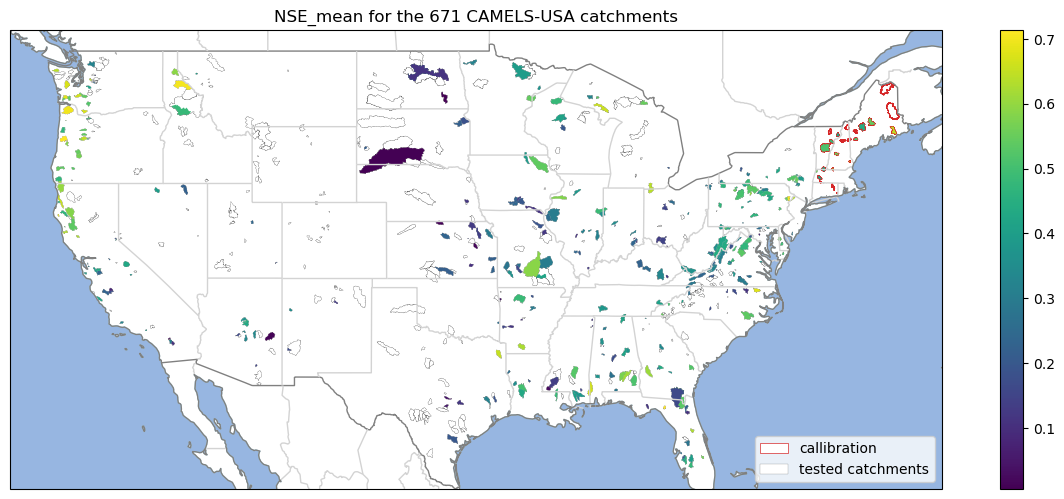

In [23]:
ax = plot_map(gdf_catchments_nse, "NSE_mean")

<GeoAxes: title={'center': 'NSE_mean_log for the 671 CAMELS-USA catchments'}>

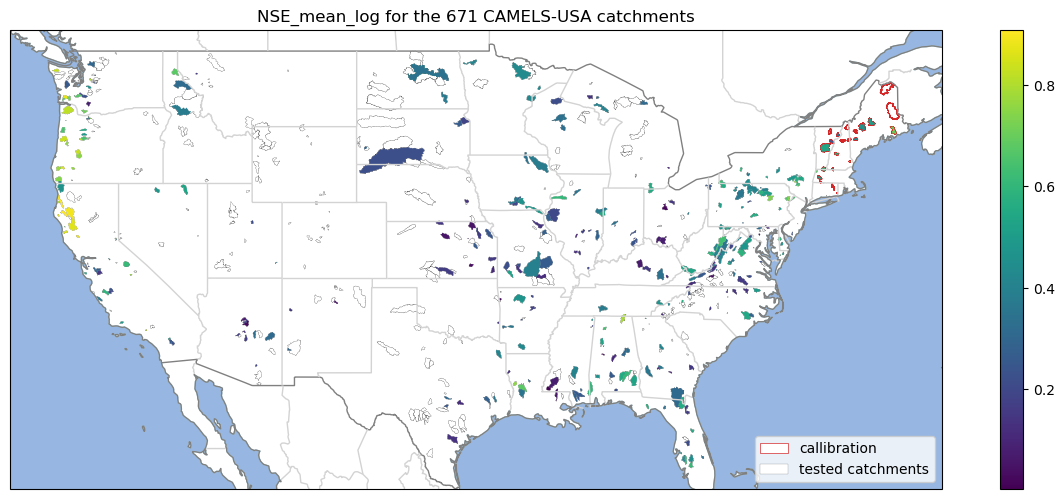

In [24]:
plot_map(gdf_catchments_nse, "NSE_mean_log")

In [25]:
ds.param.values

array(['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks', 'FM',
       'Si', 'Su', 'Sf', 'Ss', 'Sp'], dtype='<U5')

In [26]:
gdf_catchments_r2 = gdf_catchments.copy()

In [27]:
gdf_catchments_r2['hru_str'] = gdf_catchments_r2.apply(lambda x: f'0{x.name}' if len(f'{x.name}') < 8 else x.name, axis=1)

In [28]:
for param in ds.param.values:
    gdf_catchments_r2[f'r2_{param}'] = gdf_catchments_r2.apply(lambda x: float(ds.sel(HRU_id = x.hru_str,param=param)['r2'].to_numpy())
                                                              if x.hru_str in ds.HRU_id 
                                                              else np.nan, 
                                                              axis=1)
# gdf_catchments_r2['NSE_mean_log'] = gdf_catchments_r2.apply(lambda x: df_res_all.loc[int(x.name),"NSE_mean_log"] 
#                                                               if x.name in df_res_all.index 
#                                                               else np.nan, 
#                                                               axis=1)

In [29]:
gdf_catchments_r2['r2_Imax']

HRU_id
1013500     0.147825
1022500     0.801200
1030500          NaN
1031500     0.405423
1047000     0.446293
              ...   
14309500         NaN
14316700         NaN
14325000         NaN
14362250         NaN
14400000         NaN
Name: r2_Imax, Length: 671, dtype: float64

<GeoAxes: title={'center': 'r2_Ks for the 671 CAMELS-USA catchments'}>

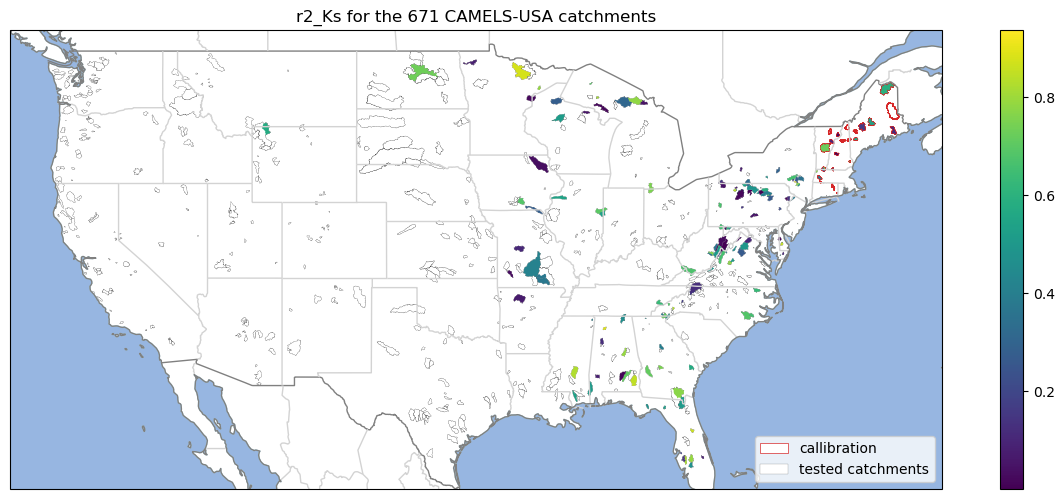

In [30]:
plot_map(gdf_catchments_r2, "r2_Ks")

<GeoAxes: title={'center': 'r2_Beta for the 671 CAMELS-USA catchments'}>

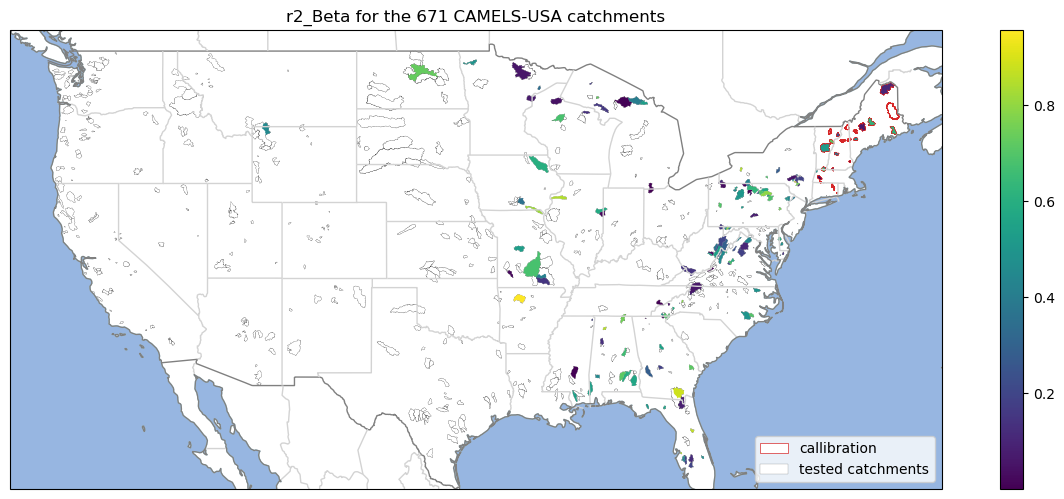

In [31]:
plot_map(gdf_catchments_r2, "r2_Beta")

<GeoAxes: title={'center': 'r2_Imax for the 671 CAMELS-USA catchments'}>

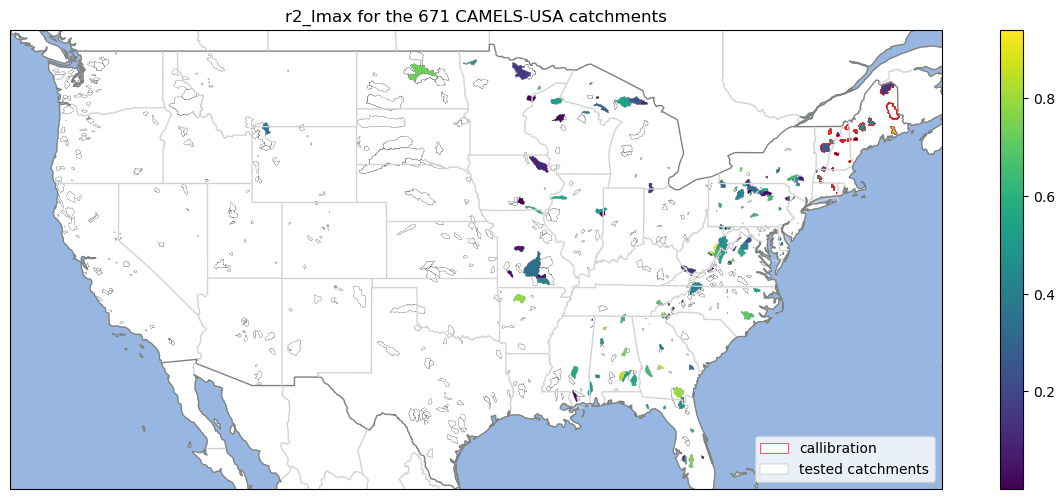

In [32]:
plot_map(gdf_catchments_r2, "r2_Imax")

# load results from callibration

In [33]:
path = Path.cwd()
file = path.parent / 'nbs_43_analyse_diff_best_callibrate' / 'DA_vs_calibrated.feather'
df_da_vs_cal = pd.read_feather(file)
df_da_vs_cal.index = [int(index) for index in df_da_vs_cal.index]
df_da_vs_cal = df_da_vs_cal[(df_da_vs_cal['NSE_best_DA'] > 0) & (df_da_vs_cal['log_NSE_best_DA'] > 0)]

In [34]:
gdf_catchments_best_DA = gdf_catchments.copy()

In [35]:
gdf_catchments_best_DA['NSE_best_DA'] = gdf_catchments_best_DA.apply(lambda x: df_da_vs_cal.loc[int(x.name),"NSE_best_DA"] 
                                                          if x.name in df_da_vs_cal.index 
                                                          else np.nan, 
                                                          axis=1)
gdf_catchments_best_DA['log_NSE_best_DA'] = gdf_catchments_best_DA.apply(lambda x: df_da_vs_cal.loc[int(x.name),"log_NSE_best_DA"] 
                                                              if x.name in df_da_vs_cal.index 
                                                              else np.nan, 
                                                              axis=1)

In [36]:
gdf_catchments_best_DA

,geometry,NSE_best_DA,log_NSE_best_DA
HRU_id,,,
1013500,"MULTIPOLYGON (((-68.35650 46.90311, -68.35612 ...",NaN,NaN
1022500,"POLYGON ((-67.97836 44.61310, -67.97800 44.613...",0.655206,0.706836
1030500,"MULTIPOLYGON (((-67.83991 45.36614, -67.83955 ...",0.412902,0.476651
1031500,"MULTIPOLYGON (((-69.33810 45.12317, -69.33800 ...",0.628023,0.621102
1047000,"POLYGON ((-70.10847 45.21669, -70.10858 45.216...",0.571648,0.713966
...,...,...,...
14309500,"POLYGON ((-123.81322 42.89103, -123.81312 42.8...",0.582315,0.891469
14316700,"POLYGON ((-122.49936 43.47688, -122.49972 43.4...",NaN,NaN
14325000,"POLYGON ((-124.07751 42.89822, -124.07716 42.8...",0.678066,0.932375


<GeoAxes: title={'center': 'NSE_best_DA for the 671 CAMELS-USA catchments'}>

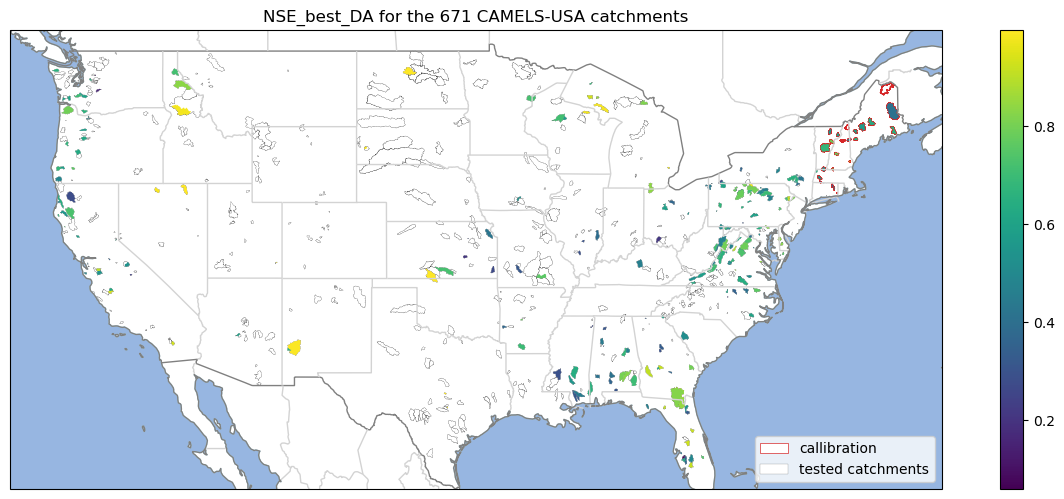

In [37]:
plot_map(gdf_catchments_best_DA, "NSE_best_DA")

<GeoAxes: title={'center': 'log_NSE_best_DA for the 671 CAMELS-USA catchments'}>

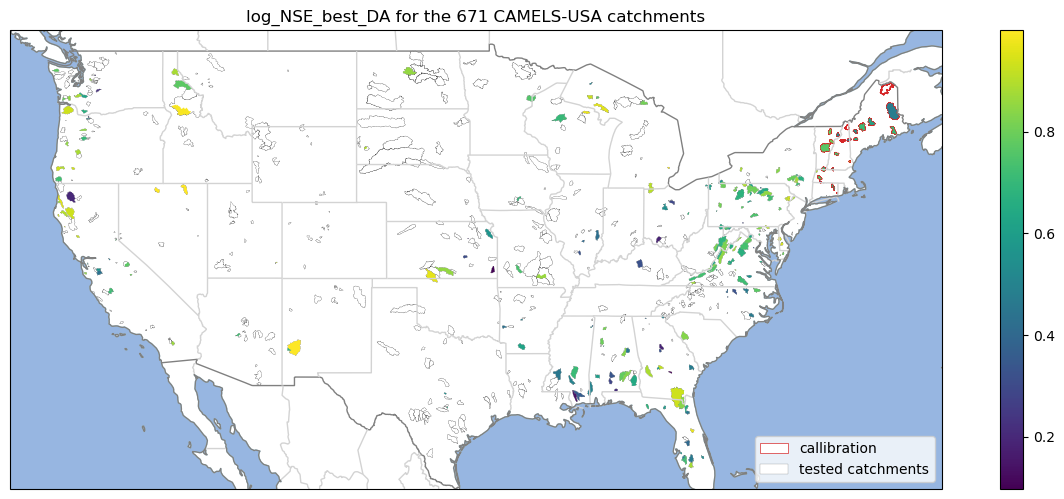

In [38]:
plot_map(gdf_catchments_best_DA, "log_NSE_best_DA")